#  1. StatsBomb에서 데이터를 불러오는 과정

In [1]:
import sys
import os

# 현재 디렉토리의 상위 폴더 경로를 구합니다.
# matplotsoccer를 설치(pip)해서 라이브러리르 사용할 수 있지만, 본 연구에서는 좀 더 시각적으로 설명하기 위해 라이브러리를 조금 수정해보았다
parent_dir = os.path.dirname(os.getcwd())

# 상위 폴더 경로를 sys.path에 추가합니다.
sys.path.insert(0, parent_dir)

In [2]:
import warnings
import pandas as pd
import matplotsoccer
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")
from tqdm import tqdm

In [3]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl

/home/toc3/anaconda3/envs/py3_11/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


### StatsBombLoader불러오기
Return a dataframe with both teams that participated in a game.

In [4]:
SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})

In [5]:
competitions = SBL.competitions()
set(competitions.competition_name)

{'1. Bundesliga',
 'Champions League',
 'Copa del Rey',
 "FA Women's Super League",
 'FIFA U20 World Cup',
 'FIFA World Cup',
 'Indian Super league',
 'La Liga',
 'Liga Profesional',
 'Ligue 1',
 'Major League Soccer',
 'NWSL',
 'North American League',
 'Premier League',
 'Serie A',
 'UEFA Euro',
 'UEFA Europa League',
 "UEFA Women's Euro",
 "Women's World Cup"}

In [6]:
competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
0,27,9,1. Bundesliga,Germany,male,2015/2016
1,4,16,Champions League,Europe,male,2018/2019
2,1,16,Champions League,Europe,male,2017/2018
3,2,16,Champions League,Europe,male,2016/2017
4,27,16,Champions League,Europe,male,2015/2016
...,...,...,...,...,...,...
65,43,55,UEFA Euro,Europe,male,2020
66,75,35,UEFA Europa League,Europe,male,1988/1989
67,106,53,UEFA Women's Euro,Europe,female,2022
68,107,72,Women's World Cup,International,female,2023


# La Liga데이터를 활용

- 연구 당시 데이터의 제한으로 인해 La Liga데이터만 활용했습니다.
- train : 2004/2005 ~ 2018/2019
- valid : 2019/2020
- test  : 2020/2021

In [7]:
train_competitions = competitions[(competitions['season_name'] <= '2019') & (competitions['competition_name'].isin(['La Liga']))]
valid_competitions = competitions[(competitions['season_name'] == '2019/2020') & (competitions['competition_name'].isin(['La Liga']))]
test_competitions = competitions[(competitions['season_name'] == '2020/2021') & (competitions['competition_name'].isin(['La Liga']))]

In [8]:
print(train_competitions.shape)
print(valid_competitions.shape)
print(test_competitions.shape)

(16, 6)
(1, 6)
(1, 6)


In [9]:
#각 데이터 로딩
data_name = ['train_competitions', 'valid_competitions', 'test_competitions']

for i, selected_competitions in enumerate([train_competitions, valid_competitions, test_competitions]):
    games = pd.concat([
        SBL.games(row.competition_id, row.season_id)
        for row in selected_competitions.itertuples()
    ])

    games_verbose = tqdm(list(games.itertuples()), desc=f'{data_name[i]} loading')
    teams, players = [], []

    actions = {}
    for game in games_verbose:  
        # load data
        teams.append(SBL.teams(game.game_id))
        players.append(SBL.players(game.game_id))
        events = SBL.events(game.game_id)
        # convert data
        actions[game.game_id] = spadl.statsbomb.convert_to_actions(events, game.home_team_id)

    teams = pd.concat(teams).drop_duplicates(subset="team_id")
    players = pd.concat(players)

    datafolder = "../data-fifa/La Liga/spadl-statsbomb/"

    # Create data folder if it doesn't exist
    if not os.path.exists(datafolder):
        os.makedirs(datafolder)
        print(f"Directory {datafolder} created.")

    spadl_h5 = os.path.join(datafolder, f"{data_name[i]}.h5")

    # Store all spadl data in h5-file
    with pd.HDFStore(spadl_h5) as spadlstore:
        spadlstore["competitions"] = selected_competitions
        spadlstore["games"] = games
        spadlstore["teams"] = teams
        spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
        spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]

        for game_id in actions.keys():
            spadlstore[f"actions/game_{game_id}"] = actions[game_id]

test_competitions loading: 100%|██████████| 35/35 [00:56<00:00,  1.62s/it]


## 한 경기 데이터 불러와서 실제 경기 플레이의 흐름을 시각화

- 레알마드리드 vs 바르셀로나 이벤트 데이터 로딩
- 영상 링크 : https://www.youtube.com/watch?v=EhodpjwTtag&t=1986s
- 12~13분에 레알마드리드가 바로셀로나를 상대로 득점한 장면에 대해서 모든 액션 가치 평가

In [10]:
datafolder = "../data-fifa/La Liga"

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb/test_competitions.h5")

with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    #Select korea vs germany game at World Cup
    game = games
    
    for i in range(len(game.game_id)):
        #레알 vs 바셀 경기만 불러오기 위해서 예외처리함
        if game.loc[i,'game_id'] != 3773497:
            continue

        game_id = game.game_id.values[i]
        
        actions = (
            spadlstore[f"actions/game_{game_id}"]
            .merge(spadl.actiontypes_df(), how="left")
            .merge(spadl.results_df(), how="left")
            .merge(spadl.bodyparts_df(), how="left")
            .merge(spadlstore["players"], how="left")
            .merge(spadlstore["teams"], how="left")
        )
        
#use nickname if available else use full name
actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)
del actions['nickname']

/tmp/ipykernel_3142067/2170458448.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)


In [11]:
actions

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name
0,3773497,4bb5ef98-f35a-46a0-86d2-4300f39bdce7,1,0.0,217,5503.0,52.058824,33.655696,61.411765,37.529114,0,1,4,0,pass,success,foot_left,Lionel Messi,Barcelona
1,3773497,bfa793ab-d82a-487a-86f0-e82e477a4add,1,1.0,217,5203.0,61.411765,37.529114,60.176471,35.893671,21,1,0,1,dribble,success,foot,Sergio Busquets,Barcelona
2,3773497,5f18fc92-4412-47db-80fe-8bb3d78da122,1,3.0,217,5203.0,60.176471,35.893671,67.147059,23.240506,0,1,5,2,pass,success,foot_right,Sergio Busquets,Barcelona
3,3773497,4cd38a62-7853-44a4-a53d-06c946aaa95e,1,5.0,217,6826.0,67.147059,23.240506,67.941176,22.207595,21,1,0,3,dribble,success,foot,Clément Lenglet,Barcelona
4,3773497,f92ab228-1310-448b-83d0-86a44ff555a1,1,6.0,217,6826.0,67.941176,22.207595,58.764706,23.756962,0,1,4,4,pass,success,foot_left,Clément Lenglet,Barcelona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359,3773497,0201ea9b-1589-4919-ada6-211d1821cd68,2,2933.0,217,39073.0,10.500000,32.794937,9.264706,32.881013,11,0,5,2359,shot,fail,foot_right,Ilaix Moriba,Barcelona
2360,3773497,NaN,2,2934.5,217,20055.0,9.264706,32.881013,15.882353,34.516456,21,1,0,2360,dribble,success,foot,Marc-André ter Stegen,Barcelona
2361,3773497,3c921c21-9d85-4720-86eb-fe708773c7bc,2,2936.0,217,20055.0,15.882353,34.516456,12.441176,33.913924,11,0,5,2361,shot,fail,foot_right,Marc-André ter Stegen,Barcelona
2362,3773497,NaN,2,2937.0,217,5211.0,12.441176,33.913924,17.117647,27.716456,21,1,0,2362,dribble,success,foot,Jordi Alba,Barcelona


2021-04-10 21:00:00 Real Madrid 2-1 Barcelona 13'


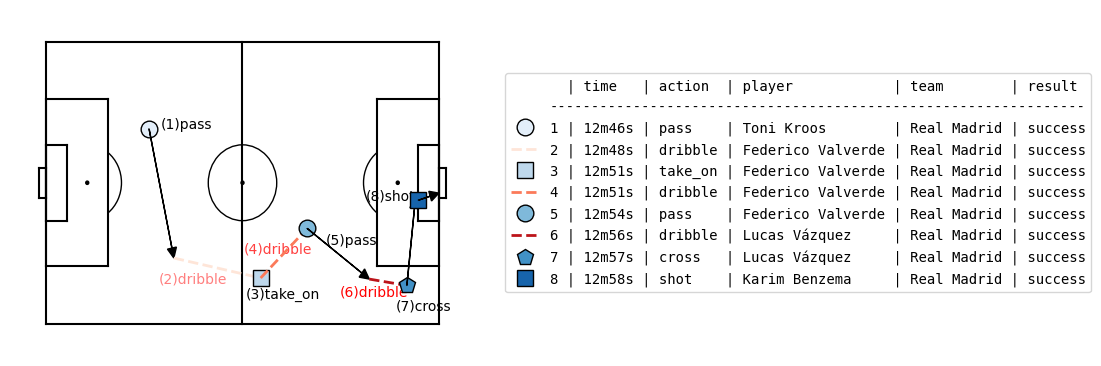

In [12]:
shot = 433
a = actions[shot-5:shot+3].copy()

# Print the game date and timestamp of the goal -> index=5 : Real Madrid vs Barcelona
g = game.iloc[5]
minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
print(game_info)

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name","result_name"]]

ax = matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time", "action", "player", "team","result"],
    zoom=False,
    figsize=6
)